## Regularization and Hyperparamter Optimization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

%matplotlib inline
plt.style.use('ggplot')

In [2]:
def select(query):
    
    conn = sqlite3.connect('./data/lending-club-loan-data/database2.sqlite')
    cursor = conn.cursor()
    temp_df = pd.DataFrame(cursor.execute(query).fetchall())
    temp_df.columns = list(map(lambda x: x[0], cursor.description))
    conn.close()
    
    return temp_df.copy()

In [3]:
features_train = select('SELECT * FROM FEATURES_TRAIN')
targets_train = select('SELECT * FROM TARGETS_TRAIN')
features_test = select('SELECT * FROM FEATURES_TEST')
targets_test = select('SELECT * FROM TARGETS_TEST')

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

In [5]:
# our scoring functions will all focus on the negative class -- we already know the model performs well on the positive class
# we are looking to optimize model performance on the negative examples. we will eventually have to consider model
# performance on the positive class as well -- can't sacrifice too much of the predictability on positives

# F1 score on the negative class may intuitively seem to be the best metric to optimize for, but in the context of loan
# portfolio optimization, it may be more important to detect bad loans -- i.e. maximize recall on the negative class,
# even if it means reduced precision and F1 (classifying many good loans as bad)

def neg_f1(targets_true,targets_predicted):
    tn, fp, fn, tp = confusion_matrix(targets_true,targets_predicted).ravel()
    precision = tn/(tn+fn)
    recall = tn/(tn+fp)
    return 2*(precision*recall)/(precision+recall)

def neg_precision(targets_true,targets_predicted):
    tn, fp, fn, tp = confusion_matrix(targets_true,targets_predicted).ravel()
    return tn/(tn+fn)

def neg_recall(targets_true,targets_predicted):
    tn, fp, fn, tp = confusion_matrix(targets_true,targets_predicted).ravel()
    return tn/(tn+fp)

---
### Logistic Regression

In [6]:
lr = LogisticRegression().fit(features_train,targets_train.loan_status)
neg_f1(targets_test.loan_status,lr.predict(features_test))

0.00044777790216052836

In [7]:
# optimize for F1, precision, recall

params = {'C':[.000001,.00001,.0001,.001,.01,.1,1,10,100,1000,10000,100000]}

lr = LogisticRegression()

#clfF1 = GridSearchCV(lr,param_grid=params,scoring=make_scorer(neg_f1),return_train_score=True)\
#    .fit(features_train,targets_train.loan_status)
#clfPREC = GridSearchCV(lr,param_grid=params,scoring=make_scorer(neg_precision),return_train_score=True)\
#    .fit(features_train,targets_train.loan_status)
#clfREC = GridSearchCV(lr,param_grid=params,scoring=make_scorer(neg_recall),return_train_score=True)\
#    .fit(features_train,targets_train.loan_status)

In [8]:
#pd.DataFrame(clfF1.cv_results_).to_csv('./data/re-lr-f1.csv')
#pd.DataFrame(clfPREC.cv_results_).to_csv('./data/re-lr-prec.csv')
#pd.DataFrame(clfREC.cv_results_).to_csv('./data/re-lr-rec.csv')

In [9]:
# we see in the three cells below that regularization on logistic regression does not do much to help the performance
# of the model. the effect of the inherent data imbalance greatly limits performance

pd.read_csv('./data/re-lr-f1.csv').drop('Unnamed: 0',axis=1)\
    .sort_values('mean_test_score',ascending=False)[['mean_test_score','param_C']]

,mean_test_score,param_C
2,0.020515,0.000100
6,0.013888,1.000000
3,0.012683,0.001000
10,0.009634,10000.000000
5,0.006705,0.100000
11,0.006033,100000.000000
9,0.002282,1000.000000
7,0.002172,10.000000
1,0.001172,0.000010
8,0.001117,100.000000


In [10]:
# the two best C values are the opposite edge cases.. odd behavior

pd.read_csv('./data/re-lr-prec.csv').drop('Unnamed: 0',axis=1)\
    .sort_values('mean_test_score',ascending=False)[['mean_test_score','param_C']]

,mean_test_score,param_C
9,0.598389,1000.000000
3,0.548325,0.001000
8,0.539683,100.000000
1,0.535405,0.000010
11,0.507672,100000.000000
4,0.498932,0.010000
5,0.480212,0.100000
2,0.473994,0.000100
7,0.451000,10.000000
10,0.440134,10000.000000


In [11]:
pd.read_csv('./data/re-lr-rec.csv').drop('Unnamed: 0',axis=1)\
    .sort_values('mean_test_score',ascending=False)[['mean_test_score','param_C']]

,mean_test_score,param_C
2,0.010705,0.000100
6,0.007239,1.000000
3,0.006596,0.001000
10,0.004891,10000.000000
5,0.003410,0.100000
11,0.003046,100000.000000
9,0.001146,1000.000000
7,0.001090,10.000000
1,0.000587,0.000010
8,0.000559,100.000000


In [12]:
# test set results

test_neg_pre = []
test_neg_rec = []

train_neg_pre = []
train_neg_rec = []

for C in params['C']:
    
    lr = LogisticRegression(C=C).fit(features_train,targets_train.loan_status)
    
    test_neg_pre.append(neg_precision(targets_test,lr.predict(features_test)))
    test_neg_rec.append(neg_recall(targets_test,lr.predict(features_test)))
    
    train_neg_pre.append(neg_precision(targets_train,lr.predict(features_train)))
    train_neg_rec.append(neg_recall(targets_train,lr.predict(features_train)))
    

Text(0.5,1,'Logistic Regression Precision: Defaults')

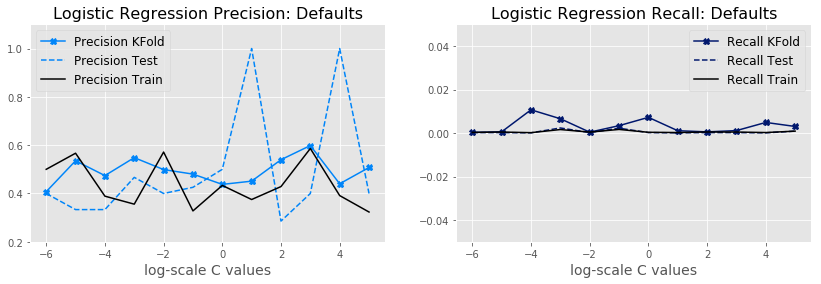

In [13]:
# the plots have the same scale on the y-axis to show the degree of difference in model performance variation

fig = plt.figure(figsize=(14,4))

ax1 = fig.add_subplot(1,2,2)
ax1.plot(pd.read_csv('./data/re-lr-rec.csv').drop('Unnamed: 0',axis=1)['param_C'].apply(lambda x: np.log10(x))\
        ,pd.read_csv('./data/re-lr-rec.csv').drop('Unnamed: 0',axis=1)['mean_test_score'],'X-',color='#00176d')
ax1.plot(pd.read_csv('./data/re-lr-rec.csv').drop('Unnamed: 0',axis=1)['param_C'].apply(lambda x: np.log10(x))\
        ,test_neg_rec,'--',color='#00176d')
ax1.plot(pd.read_csv('./data/re-lr-rec.csv').drop('Unnamed: 0',axis=1)['param_C'].apply(lambda x: np.log10(x))\
        ,train_neg_rec,'k')
ax1.legend(['Recall KFold','Recall Test','Recall Train'],fontsize=12)
ax1.set_ylim([-0.05,0.05])
ax1.set_xlabel('log-scale C values',fontsize=14)
ax1.set_title('Logistic Regression Recall: Defaults',fontsize=16)

ax2 = fig.add_subplot(1,2,1)
ax2.plot(pd.read_csv('./data/re-lr-prec.csv').drop('Unnamed: 0',axis=1)['param_C'].apply(lambda x: np.log10(x))\
        ,pd.read_csv('./data/re-lr-prec.csv').drop('Unnamed: 0',axis=1)['mean_test_score'],'X-',color='#0085f9')
ax2.legend(['Precision'],fontsize=12)
ax2.plot(pd.read_csv('./data/re-lr-prec.csv').drop('Unnamed: 0',axis=1)['param_C'].apply(lambda x: np.log10(x))\
        ,test_neg_pre,'--',color='#0085f9')
ax2.plot(pd.read_csv('./data/re-lr-rec.csv').drop('Unnamed: 0',axis=1)['param_C'].apply(lambda x: np.log10(x))\
        ,train_neg_pre,'k')
ax2.legend(['Precision KFold','Precision Test','Precision Train'],fontsize=12)
ax2.set_ylim([0.2,1.1])
ax2.set_xlabel('log-scale C values',fontsize=14)
ax2.set_title('Logistic Regression Precision: Defaults',fontsize=16)

#plt.savefig('./report/hyperparams-lr.jpg')

Text(0.5,1,'Logistic Regression Precision: Defaults')

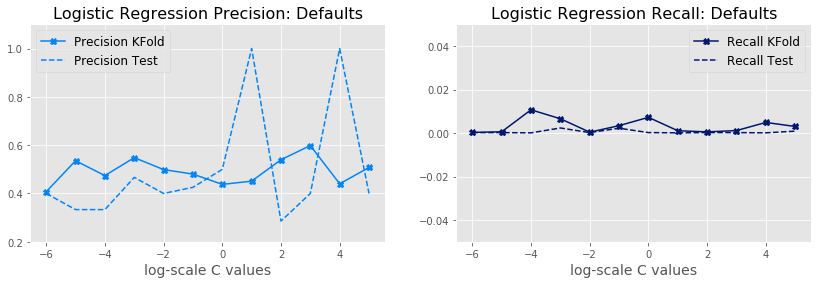

In [14]:
# the plots have the same scale on the y-axis to show the degree of difference in model performance variation

fig = plt.figure(figsize=(14,4))

ax1 = fig.add_subplot(1,2,2)
ax1.plot(pd.read_csv('./data/re-lr-rec.csv').drop('Unnamed: 0',axis=1)['param_C'].apply(lambda x: np.log10(x))\
        ,pd.read_csv('./data/re-lr-rec.csv').drop('Unnamed: 0',axis=1)['mean_test_score'],'X-',color='#00176d')
ax1.plot(pd.read_csv('./data/re-lr-rec.csv').drop('Unnamed: 0',axis=1)['param_C'].apply(lambda x: np.log10(x))\
        ,test_neg_rec,'--',color='#00176d')
ax1.legend(['Recall KFold','Recall Test'],fontsize=12)
ax1.set_ylim([-0.05,0.05])
ax1.set_xlabel('log-scale C values',fontsize=14)
ax1.set_title('Logistic Regression Recall: Defaults',fontsize=16)

ax2 = fig.add_subplot(1,2,1)
ax2.plot(pd.read_csv('./data/re-lr-prec.csv').drop('Unnamed: 0',axis=1)['param_C'].apply(lambda x: np.log10(x))\
        ,pd.read_csv('./data/re-lr-prec.csv').drop('Unnamed: 0',axis=1)['mean_test_score'],'X-',color='#0085f9')
ax2.legend(['Precision'],fontsize=12)
ax2.plot(pd.read_csv('./data/re-lr-prec.csv').drop('Unnamed: 0',axis=1)['param_C'].apply(lambda x: np.log10(x))\
        ,test_neg_pre,'--',color='#0085f9')
ax2.legend(['Precision KFold','Precision Test'],fontsize=12)
ax2.set_ylim([0.2,1.1])
ax2.set_xlabel('log-scale C values',fontsize=14)
ax2.set_title('Logistic Regression Precision: Defaults',fontsize=16)

#plt.savefig('./report/hyperparams/hyperparams-lr.jpg')

---
### Gaussian Naive-Bayes

In [15]:
from sklearn.naive_bayes import GaussianNB

In [16]:
# when estimated by the data (by default), class prior probabilities of GNB are the proportions of each class
# we can tinker with the prior probabilities to increase the model's sensitivity to certain classes. this should
# intuitively have a similar effect as resampling the dataset input to GNB without adjusting the default priors

# the first value in each pair is the prior probability of the negative class

defaultprob = list(np.linspace(0.1,0.7,13))
payoffprob = []

for x in list(np.linspace(0.1,0.7,13)):
    payoffprob.append(1-x)

params = {'priors':list(zip(defaultprob,payoffprob))}

GNB = GaussianNB()

clfF1 = GridSearchCV(GNB,param_grid=params,scoring=make_scorer(neg_f1),return_train_score=True)\
    .fit(features_train,targets_train.loan_status)
clfPREC = GridSearchCV(GNB,param_grid=params,scoring=make_scorer(neg_precision),return_train_score=True)\
    .fit(features_train,targets_train.loan_status)
clfREC = GridSearchCV(GNB,param_grid=params,scoring=make_scorer(neg_recall),return_train_score=True)\
    .fit(features_train,targets_train.loan_status)

In [17]:
gnb_ratios = []

for i in list(zip(defaultprob,payoffprob)):
    gnb_ratios.append(i[0]/i[1])

In [18]:
# for a balance between precision and recall, it seems about an even balance on prior probabilities is optimal

pd.DataFrame(clfF1.cv_results_).sort_values('mean_test_score',ascending=False)[['mean_test_score','param_priors']]

,mean_test_score,param_priors
8,0.373224,"(0.5, 0.5)"
9,0.372245,"(0.55, 0.45)"
7,0.371225,"(0.45, 0.55)"
10,0.367746,"(0.6, 0.4)"
6,0.367621,"(0.4, 0.6)"
11,0.361796,"(0.65, 0.35)"
5,0.360923,"(0.35, 0.65)"
12,0.353996,"(0.7, 0.3)"
4,0.351018,"(0.3, 0.7)"
3,0.340710,"(0.25, 0.75)"


In [19]:
# precision and recall have opposite orderings of param values. it seems that we can reduce precision for greater recall
# and vice versa. indeed, this is a very similar result to what happened with undersampling

pd.DataFrame(clfPREC.cv_results_).sort_values('mean_test_score',ascending=False)[['mean_test_score','param_priors']]

,mean_test_score,param_priors
0,0.357363,"(0.1, 0.9)"
1,0.340814,"(0.15, 0.85)"
2,0.325372,"(0.2, 0.8)"
3,0.312656,"(0.25, 0.75)"
4,0.302458,"(0.3, 0.7)"
5,0.294756,"(0.35, 0.65)"
6,0.285865,"(0.4, 0.6)"
7,0.276339,"(0.45, 0.55)"
8,0.267287,"(0.5, 0.5)"
9,0.257206,"(0.55, 0.45)"


In [20]:
pd.DataFrame(clfREC.cv_results_).sort_values('mean_test_score',ascending=False)[['mean_test_score','param_priors']]

,mean_test_score,param_priors
12,0.832392,"(0.7, 0.3)"
11,0.781805,"(0.65, 0.35)"
10,0.728144,"(0.6, 0.4)"
9,0.674343,"(0.55, 0.45)"
8,0.619088,"(0.5, 0.5)"
7,0.566014,"(0.45, 0.55)"
6,0.515315,"(0.4, 0.6)"
5,0.465679,"(0.35, 0.65)"
4,0.418306,"(0.3, 0.7)"
3,0.374399,"(0.25, 0.75)"


In [21]:
# test set results

gnb_test_neg_pre = []
gnb_test_neg_rec = []

gnb_train_neg_pre = []
gnb_train_neg_rec = []

for k in params['priors']:
    
    gnb = GaussianNB(priors=k).fit(features_train,targets_train.loan_status)
    
    predictions = gnb.predict(features_test)
    gnb_test_neg_pre.append(neg_precision(targets_test,predictions))
    gnb_test_neg_rec.append(neg_recall(targets_test,predictions))
    
    predictions = gnb.predict(features_train)
    gnb_train_neg_pre.append(neg_precision(targets_train,predictions))
    gnb_train_neg_rec.append(neg_recall(targets_train,predictions))

Text(0.5,1,'Gaussian Naive-Bayes: Defaults')

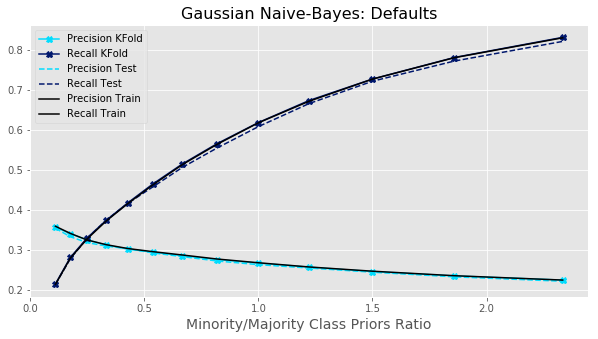

In [22]:
# the plots have the same scale on the y-axis to show the degree of difference in model performance variation

fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,1,1)
ax1.plot(gnb_ratios,pd.DataFrame(clfPREC.cv_results_)['mean_test_score'],'X-',color='#00ddff')
ax1.plot(gnb_ratios,pd.DataFrame(clfREC.cv_results_)['mean_test_score'],'X-',color='#00176d')
ax1.plot(gnb_ratios,gnb_test_neg_pre,'--',color='#00ddff')
ax1.plot(gnb_ratios,gnb_test_neg_rec,'--',color='#00176d')
ax1.plot(gnb_ratios,gnb_train_neg_pre,'k')
ax1.plot(gnb_ratios,gnb_train_neg_rec,'k')

ax1.legend(['Precision KFold','Recall KFold','Precision Test','Recall Test','Precision Train','Recall Train'])
ax1.set_xlabel('Minority/Majority Class Priors Ratio',fontsize=14)
ax1.set_title('Gaussian Naive-Bayes: Defaults',fontsize=16)

Text(0.5,1,'Gaussian Naive-Bayes: Defaults')

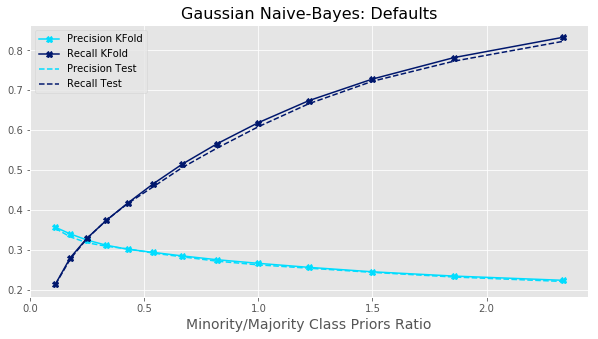

In [23]:
# the plots have the same scale on the y-axis to show the degree of difference in model performance variation

fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,1,1)
ax1.plot(gnb_ratios,pd.DataFrame(clfPREC.cv_results_)['mean_test_score'],'X-',color='#00ddff')
ax1.plot(gnb_ratios,pd.DataFrame(clfREC.cv_results_)['mean_test_score'],'X-',color='#00176d')
ax1.plot(gnb_ratios,gnb_test_neg_pre,'--',color='#00ddff')
ax1.plot(gnb_ratios,gnb_test_neg_rec,'--',color='#00176d')
ax1.legend(['Precision KFold','Recall KFold','Precision Test','Recall Test'])
ax1.set_xlabel('Minority/Majority Class Priors Ratio',fontsize=14)
ax1.set_title('Gaussian Naive-Bayes: Defaults',fontsize=16)

#plt.savefig('./report/hyperparams/hyperparams-gnb.jpg')

In [24]:
# f1 and recall are much better than in logistic regression, as seen in the baseline model w/o resampling

print(neg_f1(targets_test.loan_status,clfF1.best_estimator_.predict(features_test)))
print(neg_precision(targets_test.loan_status,clfPREC.best_estimator_.predict(features_test)))
print(neg_recall(targets_test.loan_status,clfREC.best_estimator_.predict(features_test)))

0.367787323277
0.35449833395
0.822264531302


In [25]:
GNBF1 = neg_f1(targets_test.loan_status,clfF1.best_estimator_.predict(features_test))
GNBPREC = neg_precision(targets_test.loan_status,clfPREC.best_estimator_.predict(features_test))
GNBREC = neg_recall(targets_test.loan_status,clfREC.best_estimator_.predict(features_test))

---
### k Nearest Neighbors

In [26]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
# this takes a while to compute.. commenting to remove code from future runs

params = {'n_neighbors':list(range(1,11))+[12,15,20,27,35]}

kNN = KNeighborsClassifier()

#clfF1 = GridSearchCV(kNN,param_grid=params,scoring=make_scorer(neg_f1),return_train_score=True)\
#    .fit(features_train,targets_train.loan_status)
#clfPREC = GridSearchCV(kNN,param_grid=params,scoring=make_scorer(neg_precision),return_train_score=True)\
#    .fit(features_train,targets_train.loan_status)
#clfREC = GridSearchCV(kNN,param_grid=params,scoring=make_scorer(neg_recall),return_train_score=True)\
#    .fit(features_train,targets_train.loan_status)

In [28]:
#pd.DataFrame(clfF1.cv_results_).to_csv('./data/re-knn-f1.csv')
#pd.DataFrame(clfPREC.cv_results_).to_csv('./data/re-knn-prec.csv')
#pd.DataFrame(clfREC.cv_results_).to_csv('./data/re-knn-rec.csv')

In [29]:
# overall performance is much weaker than Gaussian Naive-Bayes

pd.read_csv('./data/re-knn-f1.csv').drop('Unnamed: 0',axis=1)\
    .sort_values('mean_test_score',ascending=False)[['mean_test_score','param_n_neighbors']]

,mean_test_score,param_n_neighbors
1,0.255185,2
3,0.205052,4
0,0.203513,1
5,0.152544,6
2,0.150728,3
7,0.119035,8
4,0.107831,5
9,0.091316,10
6,0.081866,7
10,0.071858,12


In [30]:
# greater number of neighbors tends to increase precision of model

pd.read_csv('./data/re-knn-prec.csv').drop('Unnamed: 0',axis=1)\
    .sort_values('mean_test_score',ascending=False)[['mean_test_score','param_n_neighbors']]

,mean_test_score,param_n_neighbors
14,0.337669,35
12,0.300189,20
13,0.297018,27
11,0.282426,15
10,0.269905,12
9,0.259177,10
8,0.257330,9
6,0.248811,7
7,0.246623,8
4,0.230260,5


In [31]:
pd.read_csv('./data/re-knn-rec.csv').drop('Unnamed: 0',axis=1)\
    .sort_values('mean_test_score',ascending=False)[['mean_test_score','param_n_neighbors']]

,mean_test_score,param_n_neighbors
1,0.356875,2
0,0.203130,1
3,0.193013,4
5,0.114589,6
2,0.114254,3
7,0.078452,8
4,0.070402,5
9,0.055422,10
6,0.048994,7
10,0.041448,12


In [32]:
# test set results

knn_test_neg_pre = []
knn_test_neg_rec = []

for k in params['n_neighbors']:
    
    knn = KNeighborsClassifier(n_neighbors=k).fit(features_train,targets_train.loan_status)
    predictions = knn.predict(features_test)
    knn_test_neg_pre.append(neg_precision(targets_test,predictions))
    knn_test_neg_rec.append(neg_recall(targets_test,predictions))

Text(0.5,1,'k-NN: Defaults')

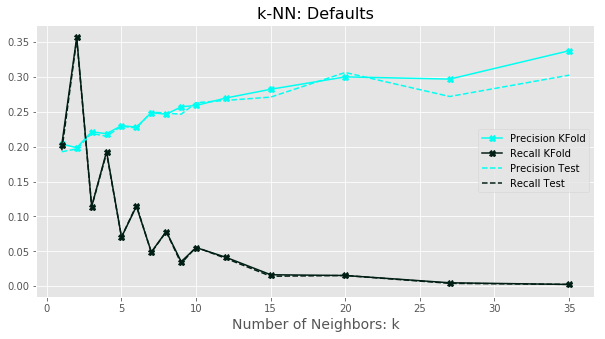

In [33]:
# as we increase k, the recall approaches 0. this is very likely because of the class imbalance. since there are so few
# minority class samples (dispersed in a sea of majority class samples), most of their neighbors will be majority class samples. 
# thus, only the samples in the very densest regions of the minority class will get classified correctly.

# it would be interesting to apply resampling and test this idea ^ (this is definitely worth doing--as an exploration of
# combining resampling with hyperparameter optimization)

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,1,1)
ax.plot(pd.read_csv('./data/re-knn-prec.csv')['param_n_neighbors'],\
        pd.read_csv('./data/re-knn-prec.csv')['mean_test_score'],'X-',color='#00fff2')
ax.plot(pd.read_csv('./data/re-knn-rec.csv')['param_n_neighbors'],\
        pd.read_csv('./data/re-knn-rec.csv')['mean_test_score'],'X-',color='#001e14')
ax.plot(pd.read_csv('./data/re-knn-prec.csv')['param_n_neighbors'],\
        knn_test_neg_pre,'--',color='#00fff2')
ax.plot(pd.read_csv('./data/re-knn-rec.csv')['param_n_neighbors'],\
        knn_test_neg_rec,'--',color='#001e14')
ax.legend(['Precision KFold','Recall KFold','Precision Test','Recall Test'])
ax.set_xlabel('Number of Neighbors: k',fontsize=14)
ax.set_title('k-NN: Defaults',fontsize=16)

#plt.savefig('./report/hyperparams/hyperparams-knn.jpg')

In [34]:
# increases in precision seem to diminish quickly on both the test set and training set

kNN1 = KNeighborsClassifier(n_neighbors=70).fit(features_train,targets_train.loan_status)
print(neg_precision(targets_train.loan_status,kNN1.predict(features_train)))
print(neg_precision(targets_test.loan_status,kNN1.predict(features_test)))
print('')
print(neg_recall(targets_train.loan_status,kNN1.predict(features_train)))
print(neg_recall(targets_test.loan_status,kNN1.predict(features_test)))

0.428571428571
0.333333333333

0.000167691447736
0.000111994624258


In [35]:
print(neg_f1(targets_test.loan_status,clfF1.best_estimator_.predict(features_test)))
print(neg_precision(targets_test.loan_status,clfPREC.best_estimator_.predict(features_test)))
print(neg_recall(targets_test.loan_status,clfREC.best_estimator_.predict(features_test)))

0.367787323277
0.35449833395
0.822264531302


In [36]:
kNNF1 = neg_f1(targets_test.loan_status,clfF1.best_estimator_.predict(features_test))
kNNPREC = neg_precision(targets_test.loan_status,clfPREC.best_estimator_.predict(features_test))
kNNREC = neg_recall(targets_test.loan_status,clfREC.best_estimator_.predict(features_test))

---
### Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
params = {'n_estimators':[5,10,15,20,30,40,60,80,100,140]}

RF = RandomForestClassifier()

#clfF1 = GridSearchCV(RF,param_grid=params,scoring=make_scorer(neg_f1),return_train_score=True)\
#    .fit(features_train,targets_train.loan_status)
#clfPREC = GridSearchCV(RF,param_grid=params,scoring=make_scorer(neg_precision),return_train_score=True)\
#    .fit(features_train,targets_train.loan_status)
#clfREC = GridSearchCV(RF,param_grid=params,scoring=make_scorer(neg_recall),return_train_score=True)\
#    .fit(features_train,targets_train.loan_status)

In [39]:
#pd.DataFrame(clfF1.cv_results_).to_csv('./data/re-rf0-f1.csv')
#pd.DataFrame(clfPREC.cv_results_).to_csv('./data/re-rf0-prec.csv')
#pd.DataFrame(clfREC.cv_results_).to_csv('./data/re-rf0-rec.csv')

In [40]:
pd.read_csv('./data/re-rf0-f1.csv').drop('Unnamed: 0',axis=1)[['mean_test_score','param_n_estimators']]

,mean_test_score,param_n_estimators
0,0.200684,5
1,0.215840,10
2,0.144222,15
3,0.159215,20
4,0.133465,30
5,0.118068,40
6,0.102185,60
7,0.100176,80
8,0.092723,100
9,0.087181,140


In [41]:
pd.read_csv('./data/re-rf0-prec.csv').drop('Unnamed: 0',axis=1)[['mean_test_score','param_n_estimators']]

,mean_test_score,param_n_estimators
0,0.312814,5
1,0.337066,10
2,0.379159,15
3,0.387320,20
4,0.401790,30
5,0.416069,40
6,0.446324,60
7,0.445317,80
8,0.455874,100
9,0.457509,140


In [42]:
pd.read_csv('./data/re-rf0-rec.csv').drop('Unnamed: 0',axis=1)[['mean_test_score','param_n_estimators']]

,mean_test_score,param_n_estimators
0,0.151649,5
1,0.157378,10
2,0.089631,15
3,0.099413,20
4,0.081191,30
5,0.070794,40
6,0.059726,60
7,0.055757,80
8,0.051817,100
9,0.047233,140


In [43]:
# test set results

import time

rf_test_neg_pre = []
rf_test_neg_rec = []
trainingtime = []

for k in params['n_estimators']:
    tic = time.time()
    rf = RandomForestClassifier(n_estimators=k).fit(features_train,targets_train.loan_status)
    toc = time.time()
    trainingtime.append(toc-tic)
    
    predictions = rf.predict(features_test)
    rf_test_neg_pre.append(neg_precision(targets_test,predictions))
    rf_test_neg_rec.append(neg_recall(targets_test,predictions))

In [59]:
#pd.DataFrame(rf_test_neg_pre).to_csv('./data/re-rf0-prec-test.csv')
#pd.DataFrame(rf_test_neg_rec).to_csv('./data/re-rf0-rec-test.csv')

Text(0.5,1,'Random Forest Training Time')

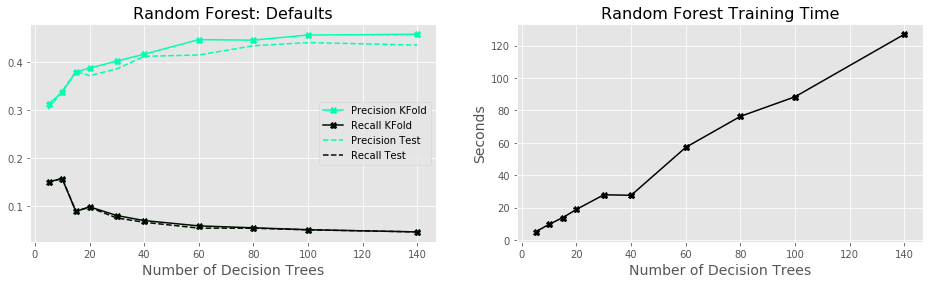

In [86]:
# recall may be decreasing because of the class imbalance. as we increase the tree count, it's more likely 
# that the majority count will be in favor of the positive class. with a resampling approach applied, recall may actually
# increase as we increase the tree count

fig = plt.figure(figsize=(16,4))

ax = fig.add_subplot(1,2,1)
ax.plot(pd.read_csv('./data/re-rf0-prec.csv')['param_n_estimators'],\
        pd.read_csv('./data/re-rf0-prec.csv')['mean_test_score'],'X-',color='#00ffb2')

ax.plot(pd.read_csv('./data/re-rf0-rec.csv')['param_n_estimators'],\
        pd.read_csv('./data/re-rf0-rec.csv')['mean_test_score'],'X-',color='#000c00')

ax.plot(pd.read_csv('./data/re-rf0-prec.csv')['param_n_estimators'],\
        pd.read_csv('./data/re-rf0-prec-test.csv').drop('Unnamed: 0',axis=1),'--',color='#00ffb2')

ax.plot(pd.read_csv('./data/re-rf0-rec.csv')['param_n_estimators'],\
        pd.read_csv('./data/re-rf0-rec-test.csv').drop('Unnamed: 0',axis=1),'--',color='#000c00')

ax.set_xlabel('Number of Decision Trees',fontsize=14)
ax.legend(['Precision KFold','Recall KFold','Precision Test','Recall Test'])
ax.set_title('Random Forest: Defaults',fontsize=16)

ax1 = fig.add_subplot(1,2,2)
ax1.plot(pd.read_csv('./data/re-rf0-prec.csv')['param_n_estimators'],\
        trainingtime,'X-',color='k')
ax1.set_ylabel('Seconds',fontsize=14)
ax1.set_xlabel('Number of Decision Trees',fontsize=14)
ax1.set_title('Random Forest Training Time',fontsize=16)

#plt.savefig('./report/hyperparams/hyperparams-rf.jpg')

In [45]:
# more estimators (trees) in a RF generally result in better performance, at computational expense. we leave this out
# of the grid search (too long to compute, otherwise) and isolate the other parameters
# param values are chosen somewhat haphazardly for this initial run. simply want to see trends w/ varying values
# choosing few values because this is too computationally expensive to run on more

# also commenting to remove from future runs

params = {'min_samples_split':[2,8,32],'min_samples_leaf':[1,16,32]}

RF = RandomForestClassifier()

#clfF1 = GridSearchCV(RF,param_grid=params,scoring=make_scorer(neg_f1),return_train_score=True)\
#    .fit(features_train,targets_train.loan_status)
#clfPREC = GridSearchCV(RF,param_grid=params,scoring=make_scorer(neg_precision),return_train_score=True)\
#    .fit(features_train,targets_train.loan_status)
#clfREC = GridSearchCV(RF,param_grid=params,scoring=make_scorer(neg_recall),return_train_score=True)\
#    .fit(features_train,targets_train.loan_status)

In [46]:
#pd.DataFrame(clfF1.cv_results_).to_csv('./data/re-rf-f1.csv')
#pd.DataFrame(clfPREC.cv_results_).to_csv('./data/re-rf-prec.csv')
#pd.DataFrame(clfREC.cv_results_).to_csv('./data/re-rf-rec.csv')

In [47]:
# for both F1 and recall, it seems tweaking the min samples does not help model performance 
# (in fact it seems to greatly reduce it..) the default values of 1 and 2 seem best

pd.read_csv('./data/re-rf-f1.csv').drop('Unnamed: 0',axis=1).sort_values('mean_test_score',ascending=False)[['mean_test_score',
                                                                                'param_min_samples_leaf',
                                                                                'param_min_samples_split']]

,mean_test_score,param_min_samples_leaf,param_min_samples_split
0,0.213364,1,2
1,0.149354,1,8
2,0.100027,1,32
4,0.072066,16,8
5,0.072056,16,32
3,0.068750,16,2
8,0.053418,32,32
6,0.051426,32,2
7,0.049348,32,8


In [48]:
# for precision, however, adjusting the min samples in a leaf seems to greatly increase the model's performance

pd.read_csv('./data/re-rf-prec.csv').drop('Unnamed: 0',axis=1).sort_values('mean_test_score',ascending=False)[['mean_test_score',
                                                                                'param_min_samples_leaf',
                                                                                'param_min_samples_split']]

,mean_test_score,param_min_samples_leaf,param_min_samples_split
6,0.508881,32,2
7,0.488280,32,8
8,0.483929,32,32
3,0.478942,16,2
5,0.474686,16,32
4,0.469063,16,8
2,0.431151,1,32
1,0.378049,1,8
0,0.334643,1,2


In [49]:
# the precision performance jumps around quite a bit as we vary minimum samples in leaeves, 
# but we are able to achieve an 'OK' level of precision (around ~0.5) on the test set..not bad

RF1 = RandomForestClassifier(min_samples_leaf=60,random_state=10).fit(features_train,targets_train.loan_status)
print(neg_precision(targets_test.loan_status,RF1.predict(features_test)))
print((RF1.predict(features_test)-1).sum()*-1)

0.5
356


In [50]:
pd.read_csv('./data/re-rf-rec.csv').drop('Unnamed: 0',axis=1).sort_values('mean_test_score',ascending=False)[['mean_test_score',
                                                                                'param_min_samples_leaf',
                                                                                'param_min_samples_split']]

,mean_test_score,param_min_samples_leaf,param_min_samples_split
0,0.159726,1,2
1,0.091923,1,8
2,0.057909,1,32
3,0.039575,16,2
4,0.038541,16,8
5,0.036780,16,32
8,0.027753,32,32
6,0.027250,32,2
7,0.026970,32,8


In [51]:
print(neg_f1(targets_test.loan_status,clfF1.best_estimator_.predict(features_test)))
print(neg_precision(targets_test.loan_status,clfPREC.best_estimator_.predict(features_test)))
print(neg_recall(targets_test.loan_status,clfREC.best_estimator_.predict(features_test)))

0.367787323277
0.35449833395
0.822264531302


In [52]:
RFF1 = neg_f1(targets_test.loan_status,clfF1.best_estimator_.predict(features_test))
RFPREC = neg_precision(targets_test.loan_status,clfPREC.best_estimator_.predict(features_test))
RFREC = neg_recall(targets_test.loan_status,clfREC.best_estimator_.predict(features_test))

---

## ADASYN and Undersampling: k-NN and random forest

In [53]:
from imblearn.over_sampling import ADASYN

ADASYNRatio = {0:len(features_train[targets_train.astype(bool).loan_status]),\
               1:len(features_train[targets_train.astype(bool).loan_status])}

features_ADASYN, targets_ADASYN = ADASYN(ratio=ADASYNRatio,random_state=2)\
    .fit_sample(features_train,targets_train.loan_status)

In [65]:
# we do not use gridsearchCV anymore, since model performance would be evaluated over CV folds of the resampled data,
# i.e. evaluation would be done over synthetic data points generated when resampling. instead, we evaluate on the 
# test set. 

params = {'n_neighbors':list(range(1,11))+[12,15,20,27,35]}

#ADASYN_neg_pre = []
#ADASYN_neg_rec = []

#for k in params['n_neighbors']:
#    kNN = KNeighborsClassifier(n_neighbors=k)
#    kNN.fit(features_ADASYN,targets_ADASYN)
#    predictions = kNN.predict(features_test)

    #ADASYN_neg_pre.append(neg_precision(targets_test,predictions))
    #ADASYN_neg_rec.append(neg_recall(targets_test,predictions))


In [66]:
#pd.DataFrame(ADASYN_neg_pre).to_csv('./data/ADASYN-re-knn-prec.csv')
#pd.DataFrame(ADASYN_neg_rec).to_csv('./data/ADASYN-re-knn-rec.csv')

Text(0.5,1,'k-NN: Defaults (ADASYN Resampled 1:1)')

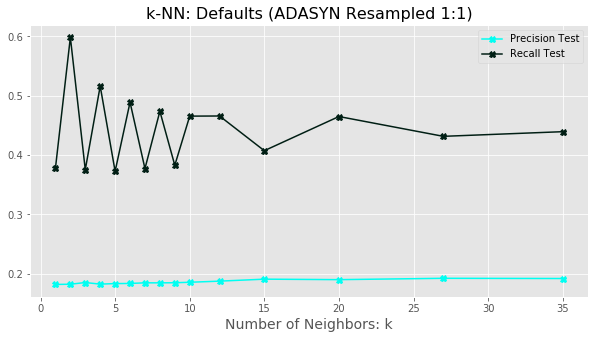

In [85]:
# as we increase k, the recall approaches 0. this is very likely because of the class imbalance. since there are so few
# minority class samples (dispersed in a sea of majority class samples), most of their neighbors will be majority class samples. 
# thus, only the samples in the very densest regions of the minority class will get classified correctly.

# it would be interesting to apply resampling and test this idea ^ (this is definitely worth doing--as an exploration of
# combining resampling with hyperparameter optimization)

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,1,1)
ax.plot(params['n_neighbors'],\
        pd.read_csv('./data/ADASYN-re-knn-prec.csv').drop('Unnamed: 0',axis=1),'X-',color='#00fff2')

ax.plot(params['n_neighbors'],\
        pd.read_csv('./data/ADASYN-re-knn-rec.csv').drop('Unnamed: 0',axis=1),'X-',color='#001e14')

ax.legend(['Precision Test','Recall Test'])
ax.set_xlabel('Number of Neighbors: k',fontsize=14)
ax.set_title('k-NN: Defaults (ADASYN Resampled 1:1)',fontsize=16)

#plt.savefig('./report/hyperparams/ADASYN-hyperparams-knn.jpg')

In [98]:
from imblearn.under_sampling import RandomUnderSampler

USRatio = {0:len(features_train[~targets_train.astype(bool).loan_status]),\
           1:len(features_train[~targets_train.astype(bool).loan_status])}

features_US, targets_US = RandomUnderSampler(ratio=USRatio,random_state=2)\
    .fit_sample(features_train,targets_train.loan_status)

In [99]:
# this takes a while to compute.. commenting to remove code from future runs

params = {'n_estimators':[5,10,15,20,30,40,60,80,100,140]}

US_neg_pre = []
US_neg_rec = []

for k in params['n_estimators']:
    rf = RandomForestClassifier(n_estimators=k)
    rf.fit(features_US,targets_US)
    predictions = rf.predict(features_test)

    US_neg_pre.append(neg_precision(targets_test,predictions))
    US_neg_rec.append(neg_recall(targets_test,predictions))

In [100]:
#pd.DataFrame(US_neg_pre).to_csv('./data/US-re-rf-prec.csv')
#pd.DataFrame(US_neg_rec).to_csv('./data/US-re-rf-rec.csv')

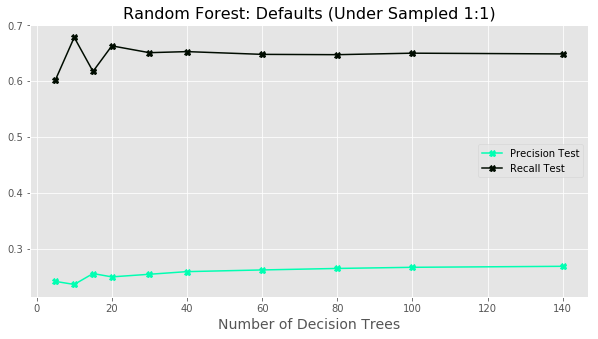

In [103]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,1,1)
ax.plot(params['n_estimators'],\
        pd.read_csv('./data/US-re-rf-prec.csv').drop('Unnamed: 0',axis=1),'X-',color='#00ffb2')

ax.plot(params['n_estimators'],\
        pd.read_csv('./data/US-re-rf-rec.csv').drop('Unnamed: 0',axis=1),'X-',color='#000c00')

ax.legend(['Precision Test','Recall Test'])
ax.set_xlabel('Number of Decision Trees',fontsize=14)
ax.set_title('Random Forest: Defaults (Under Sampled 1:1)',fontsize=16)

#plt.savefig('./report/hyperparams/US-hyperparams-rf.jpg')